In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy
import arviz
from adaptive_nof1.models import Model, DiscretizedModel
from adaptive_nof1.basic_types import Outcome
import sklearn
from sklearn.metrics import classification_report

RED_PILL = 1
BLUE_PILL = 2


class PillModel(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.red_pill_slope = self.rng.normal(0, 1)
        self.blue_pill_slope = self.rng.normal(0, 1)

    def generate_context(self, history):
        return {"time_of_the_day": numpy.sin(len(history) / 3)}

    def observe_outcome(self, action, context):
        if action["treatment"] == RED_PILL:
            return {"enlightment": context["time_of_the_day"] * self.red_pill_slope}
        else:
            return {"enlightment": context["time_of_the_day"] * self.blue_pill_slope}

    def __str__(self):
        return f"PillModel"

## With the data generating model set, we can now set up a simulation study.
Let's say we want to compare the performance between a fixed allocation of red and blue pills and an epsilon-greedy bandit approach.

Let's first define some constants.


In [5]:
# Simulation constants
data_generating_model = lambda patient_id: DiscretizedModel(
    PillModel(patient_id), outcome_name="enlightment"
)

length = 100
number_of_actions = 2
number_of_patients = 1

In [6]:
from adaptive_nof1 import SeriesOfSimulations
from adaptive_nof1.policies import (
    FixedPolicy,
    FrequentistEpsilonGreedy,
    FrequentistExploreThenCommit,
    ThompsonSampling,
)
from adaptive_nof1.inference import BernoulliLogItInferenceModel

fixed_schedule_series = SeriesOfSimulations(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=FixedPolicy(number_of_actions=number_of_actions),
    length=length,
)

# Idea: Estimate different slope for each treatment and then select the best variant
inference_model = BernoulliLogItInferenceModel(
    effect_variance=1,
    random_variance=1,
    coefficient_names=["time_of_the_day"],
    outcome_name="discrete_enlightment",
)

adaptive_series = SeriesOfSimulations(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=ThompsonSampling(
        inference_model=inference_model,
        number_of_actions=2,
        posterior_update_interval=50,
    ),
    length=length,
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/pymc/model.py:2048: ShapeWarning: You are resizing a variable with dimension 'obs_id' which was initialized as a mutable dimension by another variable ('treatment_selection_matrix'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/pymc/model.py:2048: ShapeWarning: You are resizing a variable with dimension 'obs_id' which was initialized as a mutable dimension by another variable ('treatment_selection_matrix'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


Sampling: []


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'slopes'}>,
        <Axes: title={'center': 'slopes'}>],
       [<Axes: title={'center': 'linear_regression'}>,
        <Axes: title={'center': 'linear_regression'}>],
       [<Axes: title={'center': 'linear_regression_transformed'}>,
        <Axes: title={'center': 'linear_regression_transformed'}>]],
      dtype=object)

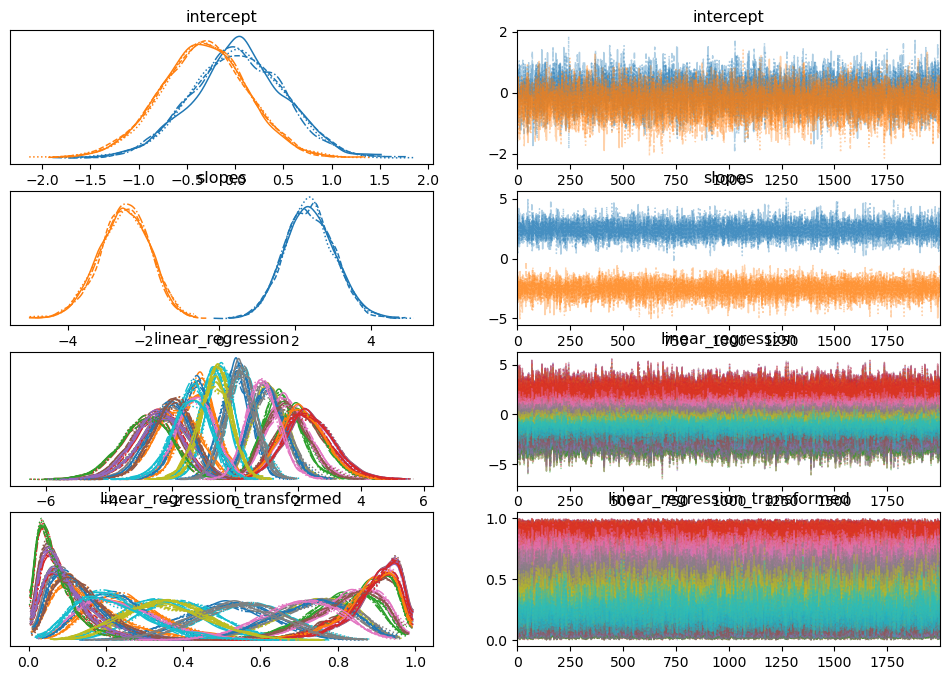

In [7]:
arviz.plot_trace(adaptive_series.simulations[0].policy.inference.trace)

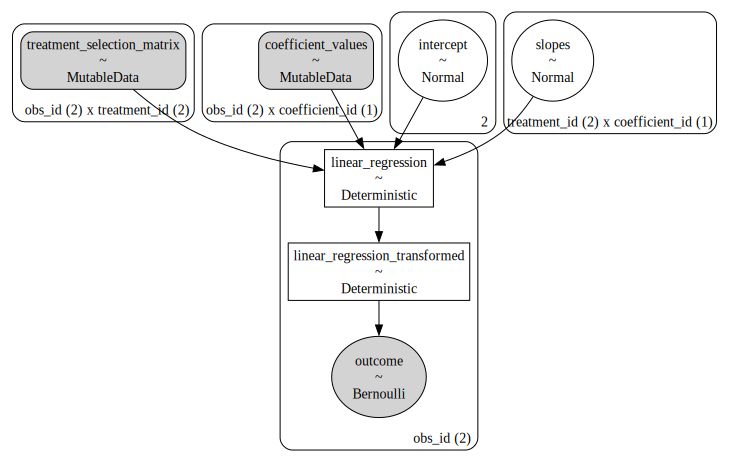

In [8]:
import pymc

pymc.model_to_graphviz(adaptive_series.simulations[0].policy.inference.model)

In [9]:
print(adaptive_series.simulations[0].model.continuous_model.red_pill_slope)
print(adaptive_series.simulations[0].model.continuous_model.blue_pill_slope)

0.1257302210933933
-0.1321048632913019


The framework provides different plots to test the performance. One simple one is the regret over time graph:

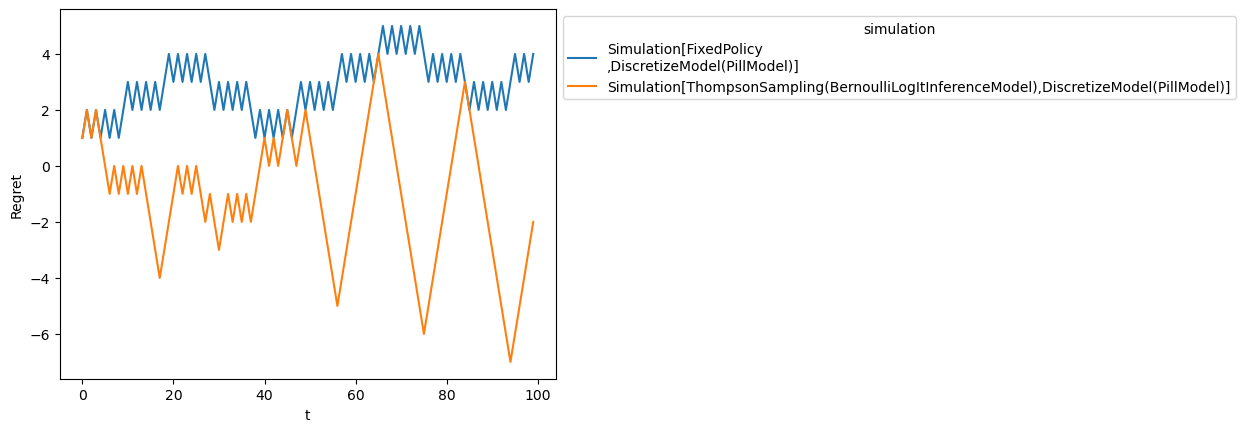

In [10]:
from adaptive_nof1.metrics import SimpleRegret

series = [
    fixed_schedule_series,
    adaptive_series,
]

SeriesOfSimulations.plot_lines(
    series, SimpleRegret(outcome_name="discrete_enlightment")
)

In [11]:
fixed_schedule_series.plot_allocations()

HoloViews(HeatMap, height=300, sizing_mode='fixed', width=700)

In [12]:
adaptive_series.plot_allocations()

HoloViews(HeatMap, height=300, sizing_mode='fixed', width=700)

In [17]:
simulation = adaptive_series.simulations[0]
model = simulation.policy.inference
print(model.classification_scores(simulation.history, 2))

Sampling: [outcome]


              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85        49
         1.0       0.89      0.78      0.83        51

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



In [218]:
simulation = adaptive_series.simulations[0]
inference = simulation.policy.inference
model = simulation.policy.inference.model
trace = simulation.policy.inference.trace

simulation = fixed_schedule_series.simulations[0]

inference.update_posterior(simulation.history, 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


In [219]:
with model:
    pymc.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [outcome]


In [225]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [226]:
predicted_outcome = arviz.extract(
    trace.posterior_predictive, var_names="outcome", num_samples=1
)
outcome = trace.observed_data["outcome"]
print(outcome.shape)

(1000,)


In [227]:
print(sklearn.metrics.classification_report(y_true=outcome, y_pred=predicted_outcome))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       502
           1       0.92      0.93      0.92       498

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

